## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Воронов |
|---------|--------|
| Группа  | 7      |

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

In [1]:
import matplotlib.pyplot as plt 
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os

In [11]:
!rm -rf mnist.pkl.gz mnist.pkl

!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9.9M  100  9.9M    0     0  40.4M      0 --:--:-- --:--:-- --:--:-- 40.4M


Теперь загружаем датасет:

In [12]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [13]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

Смотрим на то, какие данные получились:

In [14]:
data.shape

(42000, 784)

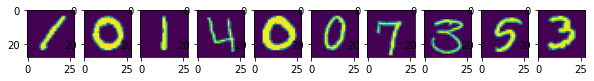

In [15]:
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(data[i].reshape(28,28))
pylab.show()

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку

In [16]:
n = 42000

# Разбиваем на обучающую и тестовые выборки
train_x, test_x = np.split(data, [n*8//10])
train_labels, test_labels = np.split(labels, [n*8//10])

# Основные функции и классы

In [17]:
class Net:
    
    def __init__(self, loss_function, alg):
        self.layers = []
        self.alg = alg
        self.loss = loss_function()
    
    def add(self, l):
        self.layers.append(l)
        
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self, z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self, lr):
        self.alg.update(self, lr)
    
    def forward_loss(self, p, y):
        return self.loss.forward(p, y)
    
    
    def backward_loss(self, loss):
        return self.loss.backward(loss)
         
    
    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.forward_loss(p, y)
        pred = np.argmax(p, axis = 1)
        acc = (pred == y).mean()
        return l, acc
    
    def train_epoch(self, train_x, train_labels, batch_size, lr):
        for i in range(0, len(train_x), batch_size):
            xb = train_x[i:i + batch_size]
            yb = train_labels[i:i + batch_size]

            #Метод наискорейшего градиентного спуска
            l = 0.5
            r = 400
            
            while(r - l < 0.000001):
                a = l + (r - l) / 3
                b = l + 2 * (r - l) / 3
                net.update(lr * a)
                p = self.forward(xb)
                fa = self.forward_loss(p, yb)
                net.update(- lr * a)
                
                net.update(lr * b)
                p = self.forward(xb)
                fb = self.forward_loss(p, yb)
                net.update(- lr * b)
                
                if fb > fa:
                    r = b
                else:
                    l = a
            
            
            p = self.forward(xb)
            loss = self.forward_loss(p, yb)
            dp = self.backward_loss(loss)    
            dx = self.backward(dp)
            net.update(lr * l)
        
    def train(self, n_epoch, train_x, train_labels, test_x, test_labels, batch_size, lr):
        graphics = [[], []]
        for i in range(n_epoch):
            self.train_epoch(train_x, train_labels, batch_size, lr)
            train_loss, train_acc = net.get_loss_acc(train_x, train_labels)
            test_loss, test_acc = net.get_loss_acc(test_x, test_labels)
            graphics[0].append(train_acc)
            graphics[1].append(test_acc)
        return graphics
            
    def draw_confusion_matrix_and_graphics(self, x, labels, n, graphics):
        p = self.forward(x)
        res = np.argmax(p, axis = 1)
        con_matrix = []
        for i in range(n):
            con_matrix.append([0]*n)
            
        for i in range(len(res)):
            con_matrix[res[i]][labels[i]] += 1
            
        figure = plt.figure(figsize = (17, 5))
        axes = figure.add_subplot(121)
        caxes = axes.matshow(con_matrix)
        figure.colorbar(caxes)
        
        axes = figure.add_subplot(122)
        plt.plot(graphics[0], 'r')
        plt.plot(graphics[1], 'b')
        plt.show()
        

In [18]:
class Gradient_Descent:
    
    def update(net, lr):
        for l in net.layers:
            if 'update' in l.__dir__():
                l.update(lr)

In [19]:
class Linear:
    def __init__(self, nin, nout):
        self.W = np.random.normal(0, 1.0 / np.sqrt(2 * nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis = 0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db

In [20]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis = 1,keepdims = True)
        expz = np.exp(z - zmax)
        Z = expz.sum(axis = 1,keepdims = True)
        return expz / Z
    
    def backward(self, dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis = 1, keepdims = True)

In [21]:
class CrossEntropyLoss:
    def forward(self, p, y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    
    def backward(self, loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0 / len(self.y)
        return dlog_softmax / self.p

In [22]:
class MeanSquareError:
    def forward(self, p, y):
        self.p = p
        self.y = y
        
        sum = 0
        for i in range(len(p)):
            for j in range(len(p[i])):
                if j == y[i]:
                    sum += (p[i][j] - 1) ** 2
                else:
                    sum += p[i][j] ** 2
        return sum 
        
    def backward(self, loss):
        sum = np.zeros(self.p.shape)
        for i in range(len(self.p)):
            for j in range(len(self.p[i])):
                if j == self.y[i] :
                    sum[i][j] += 2.0 * (self.p[i][j] - 1)
                else:
                    sum[i][j] += 2.0 * self.p[i][j]
        return sum 

## Однослойная сеть

Количество эпох - 10

Размер батча - 4

Шаг градиента - 0.0000075

Функция ошибки - CrossEntropyLoss

Initial loss=80.94577671015789, accuracy=0.08264880952380953: 


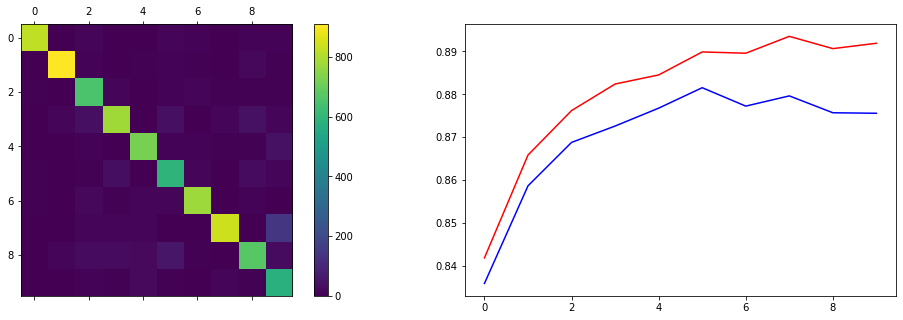

Final loss=1.3083839958437036, accuracy=0.8919047619047619: 
Test loss=1.7656549146023348, accuracy=0.8755952380952381: 


In [23]:
net = Net(CrossEntropyLoss, Gradient_Descent)
net.add(Linear(784,10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = [[], []]
graphics = net.train(10, train_x, train_labels, test_x, test_labels, 4, 0.0000075)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)
    
print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 15

Размер батча - 20

Шаг градиента - 0.00008

Функция ошибки - CrossEntropyLoss

Initial loss=115.22097832198511, accuracy=0.12976190476190477: 


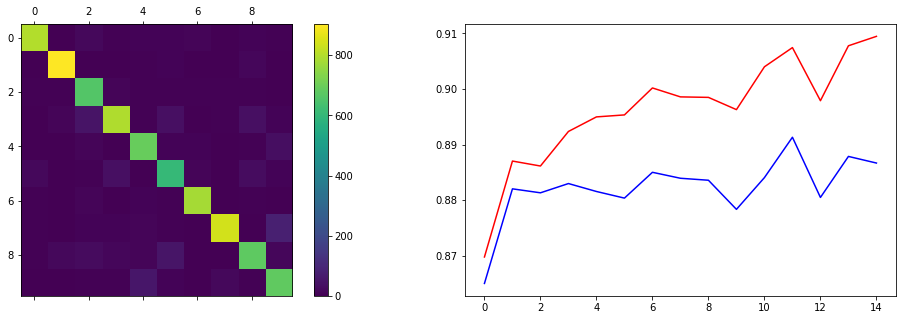

Final loss=1.162856742643162, accuracy=0.9094642857142857: 
Test loss=1.6396143039660838, accuracy=0.8866666666666667: 


In [24]:
net = Net(CrossEntropyLoss, Gradient_Descent)
net.add(Linear(784,10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = [[], []]
graphics = net.train(15, train_x, train_labels, test_x, test_labels, 20, 0.00008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)
    
print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 20

Размер батча - 6

Шаг градиента - 0.0001

Функция ошибки - MeanSquareError

Initial loss=92610.97269638653, accuracy=0.21741666666666667: 


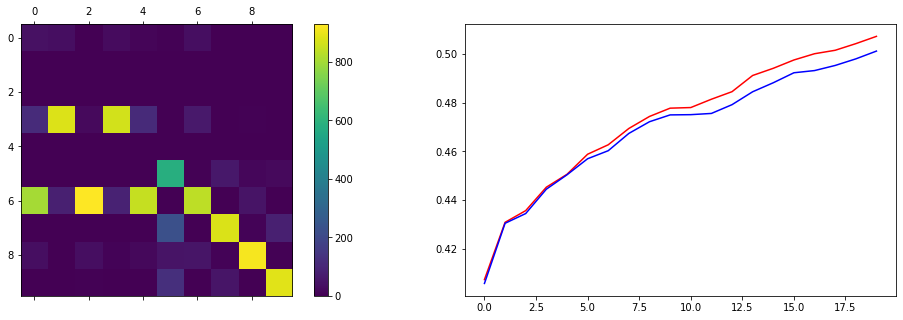

Final loss=58722.48611275253, accuracy=0.50725: 
Test loss=9895.061311464919, accuracy=0.5012: 


In [45]:
net = Net(MeanSquareError, Gradient_Descent)
net.add(Linear(784, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = [[], []]
graphics = net.train(20, train_x, train_labels, test_x, test_labels, 6, 0.000001)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)
    
print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 40

Размер батча - 2

Шаг градиента - 0.000001

Функция ошибки - MeanSquareError

Initial loss=59299.12836138798, accuracy=0.10657738095238095: 


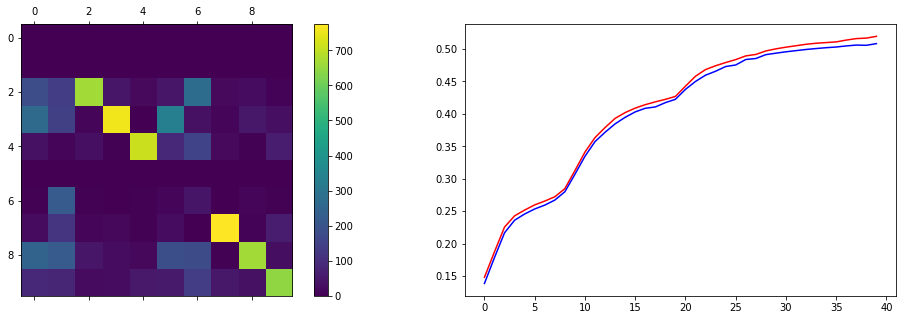

Final loss=31696.45311457112, accuracy=0.5196428571428572: 
Test loss=8103.408902532123, accuracy=0.508452380952381: 


In [26]:
net = Net(MeanSquareError, Gradient_Descent)
net.add(Linear(784,10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = [[], []]
graphics = net.train(40, train_x, train_labels, test_x, test_labels, 2, 0.000001)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)
    
print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

# Многослойная сеть

In [27]:
class Tanh:
    def forward(self, x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self, dy):
        return (1.0 - self.y ** 2) * dy

Количество эпох - 10

Размер батча - 1

Количество слоёв - 2

Шаг градиента - 0.000008

Функция ошибки - CrossEntropyLoss

Предаточная функция - Tanh

Initial loss=2.5502317641250625, accuracy=0.09580357142857143: 


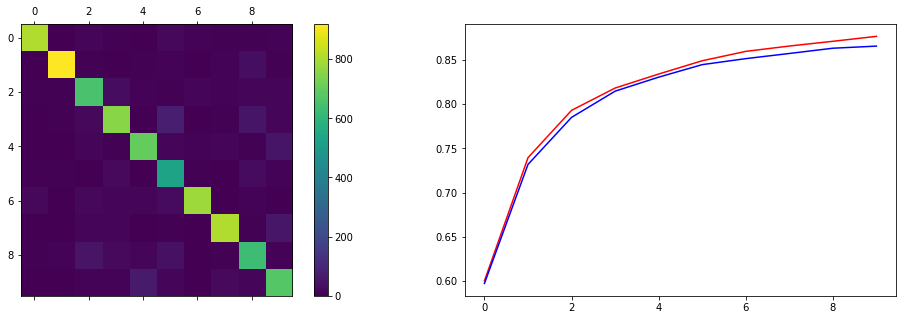

Final loss=0.5299524252967817, accuracy=0.8766369047619048: 
Test loss=0.5533881898400352, accuracy=0.8655952380952381: 


In [28]:
net = Net(CrossEntropyLoss, Gradient_Descent)

net.add(Linear(784, 128))
net.add(Tanh())
net.add(Linear(128, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = net.train(10, train_x, train_labels, test_x, test_labels, 1, 0.000008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))


Количество эпох - 10

Размер батча - 5

Количество слоёв - 3

Шаг градиента - 0.000075

Функция ошибки - MeanSquareError

Предаточная функция - Tanh

Initial loss=2.3880802126840033, accuracy=0.08333333333333333: 


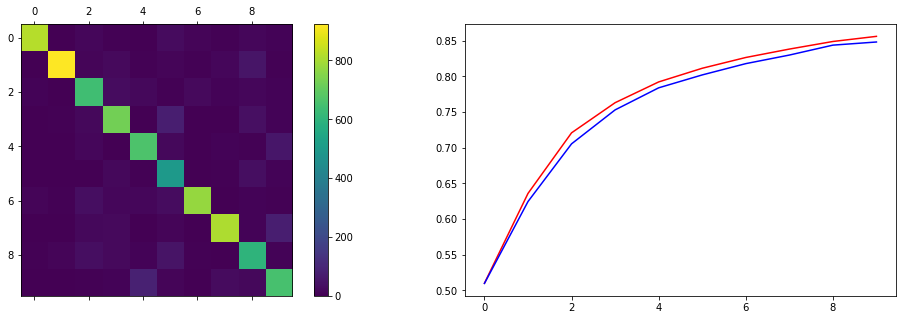

Final loss=0.8112646291339675, accuracy=0.85625: 
Test loss=0.8201177401448043, accuracy=0.8483333333333334: 


In [29]:
net = Net(CrossEntropyLoss, Gradient_Descent)

net.add(Linear(784, 64))
net.add(Tanh())
net.add(Linear(64, 32))
net.add(Tanh())
net.add(Linear(32, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = net.train(10, train_x, train_labels, test_x, test_labels, 5, 0.000075)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))


In [30]:
class ReLU:
    def forward(self, x):
        self.y = x
        self.y[self.y < 0] = 0
        return self.y
    def backward(self, dy):
        self.y[self.y > 0] = 1
        return self.y * dy

Количество эпох - 10

Размер батча - 20

Количество слоёв - 3

Шаг градиента - 0.000008

Функция ошибки - CrossEntropyLoss

Предаточная функция - ReLu

Initial loss=37.0377146197517, accuracy=0.14794642857142856: 


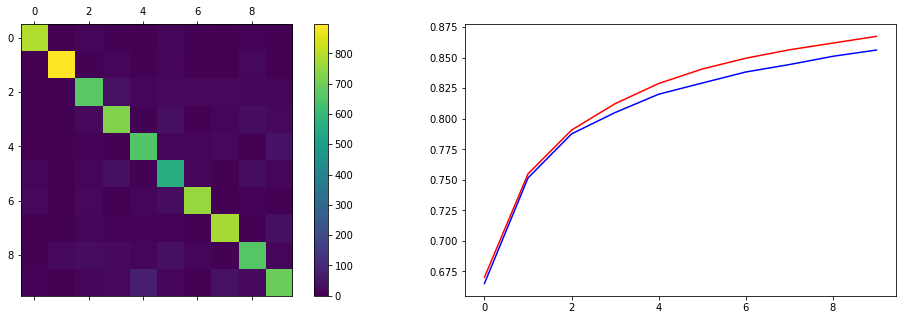

Final loss=1.2294545264093122, accuracy=0.8675297619047619: 
Test loss=1.436324476559893, accuracy=0.8563095238095239: 


In [31]:
net = Net(CrossEntropyLoss, Gradient_Descent)
net.add(Linear(784, 128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x,train_labels)))

graphics =  net.train(10, train_x, train_labels, test_x, test_labels, 20, 0.000008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 25

Размер батча - 4

Количество слоёв - 3

Шаг градиента - 0.000008

Функция ошибки - MeanSquareError

Предаточная функция - ReLu

Initial loss=103635.8837795593, accuracy=0.09785: 


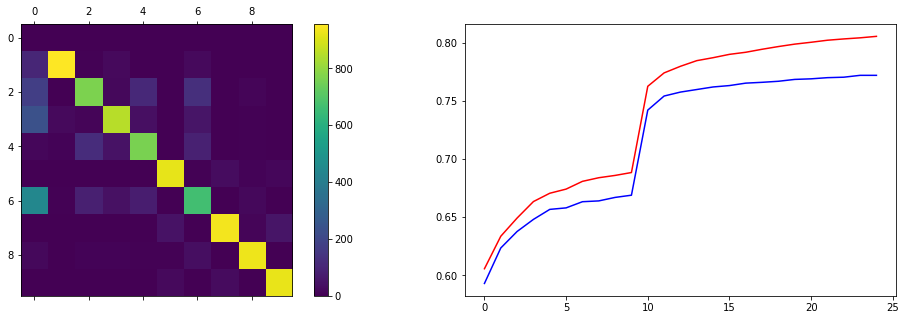

Final loss=17615.19315240699, accuracy=0.8056333333333333: 
Test loss=3380.2769244075575, accuracy=0.7721: 


In [44]:
net = Net(MeanSquareError, Gradient_Descent)
net.add(Linear(784, 100))
net.add(ReLU())
net.add(Linear(100, 96))
net.add(ReLU())
net.add(Linear(96, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x,train_labels)))

graphics =  net.train(25, train_x, train_labels, test_x, test_labels, 4, 0.000008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

# FashionMNIST

In [2]:
!rm -rf *.gz

!curl -o test-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
!curl -o test-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-labels-idx1-ubyte.gz
!curl -o train-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz
!curl -o train-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-labels-idx1-ubyte.gz

import gzip
with gzip.open("test-labels.gz", "rb") as gz:
    test_labels = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("test-images.gz", "rb") as gz:
    test_x = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(test_labels), 784)
    
with gzip.open("train-labels.gz", "rb") as gz:
    train_labels = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("train-images.gz", "rb") as gz:
    train_x = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(train_labels), 784)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4318k  100 4318k    0     0  3306k      0  0:00:01  0:00:01 --:--:-- 3306k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5148  100  5148    0     0  16291      0 --:--:-- --:--:-- --:--:-- 16291
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.1M  100 25.1M    0     0  4725k      0  0:00:05  0:00:05 --:--:-- 5026k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29515  100 29515    0     0   112k      0 --:--:-- --:--:-- --:--:--  112k


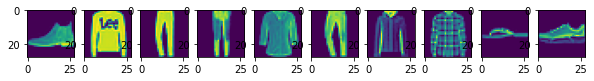

In [34]:
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(test_x[i].reshape(28,28))
pylab.show()

Количество эпох - 15

Размер батча - 20

Количество слоёв - 1

Шаг градиента - 0.00008

Функция ошибки - CrossEntropyLoss

Initial loss=97.96932603091571, accuracy=0.09878333333333333: 


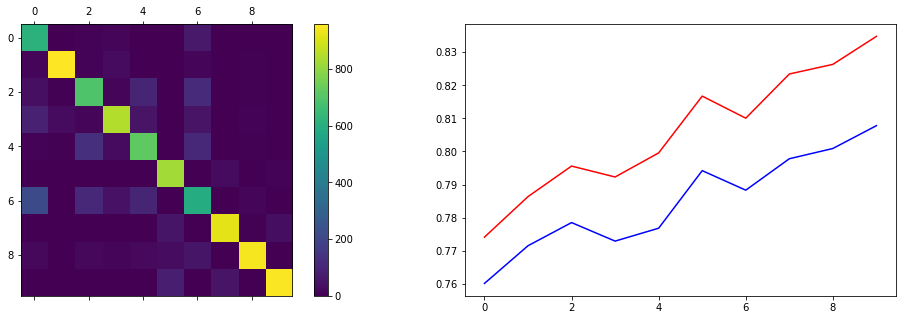

Final loss=2.012199558376354, accuracy=0.8348: 
Test loss=2.764293084951104, accuracy=0.8078: 


In [35]:
net = Net(CrossEntropyLoss, Gradient_Descent)
net.add(Linear(784,10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = [[], []]
graphics = net.train(15, train_x, train_labels, test_x, test_labels, 20, 0.00008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)
    
print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 20

Размер батча - 2

Количество слоёв - 3

Шаг градиента - 0.000008

Функция ошибки - MeanSquareError

Предаточная функция - Tanh

Initial loss=54217.00058561943, accuracy=0.10028333333333334: 


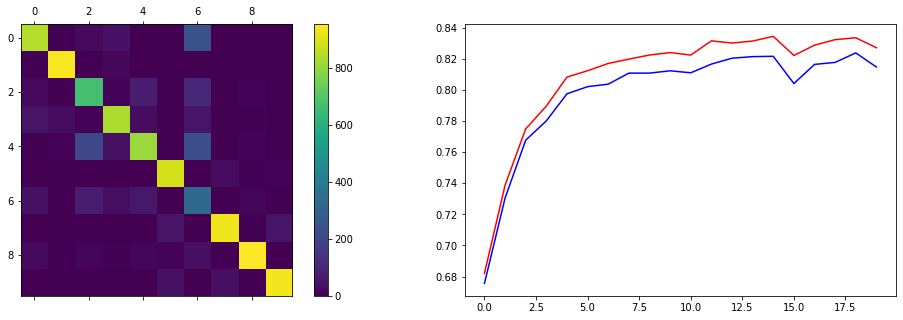

Final loss=15486.091189007793, accuracy=0.8271: 
Test loss=2731.834203768867, accuracy=0.8147: 


In [41]:
net = Net(MeanSquareError, Gradient_Descent)

net.add(Linear(784, 128))
net.add(Tanh())
net.add(Linear(128, 32))
net.add(Tanh())
net.add(Linear(32, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = net.train(20, train_x, train_labels, test_x, test_labels, 2, 0.00008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))


Количество эпох - 10

Размер батча - 6

Количество слоёв - 3

Шаг градиента - 0.00001

Функция ошибки - CrossEntropyLoss

Предаточная функция - ReLU

Initial loss=23.0031182331412, accuracy=0.10711666666666667: 


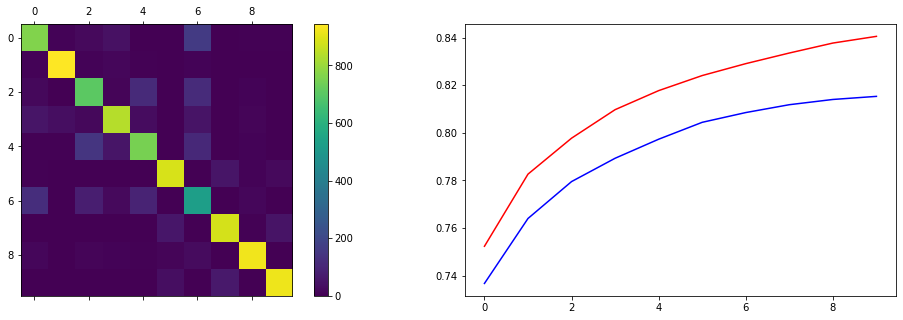

Final loss=0.49158438572564545, accuracy=0.8405166666666667: 
Test loss=0.5964022611957098, accuracy=0.8153: 


In [39]:
net = Net(CrossEntropyLoss, Gradient_Descent)

net.add(Linear(784, 196))
net.add(ReLU())
net.add(Linear(196, 128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = net.train(10, train_x, train_labels, test_x, test_labels, 6, 0.00001)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))


Количество эпох - 10

Размер батча - 6

Количество слоёв - 3

Шаг градиента - 0.00001

Функция ошибки - CrossEntropyLoss

Предаточная функция - Tanh

Initial loss=2.3537130502260672, accuracy=0.06888333333333334: 


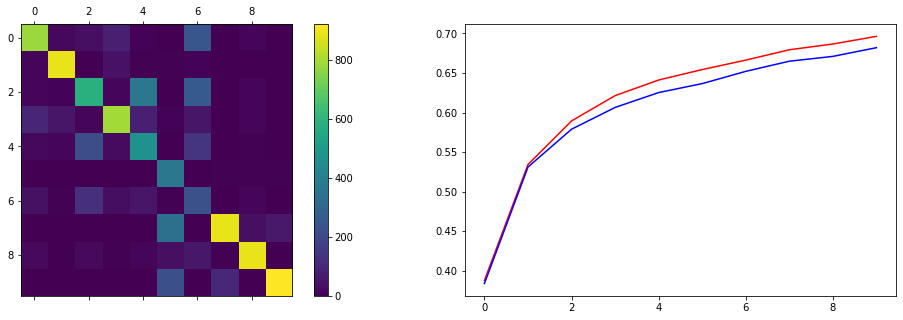

Final loss=1.22492001212159, accuracy=0.6962166666666667: 
Test loss=1.2391614432659304, accuracy=0.6819: 


In [43]:
net = Net(CrossEntropyLoss, Gradient_Descent)

net.add(Linear(784, 200))
net.add(Tanh())
net.add(Linear(200, 150))
net.add(Tanh())
net.add(Linear(150, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = net.train(10, train_x, train_labels, test_x, test_labels, 6, 0.00001)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))
